In [13]:
import pandas as pd 
import os
import numpy as np
import seaborn as sb
from analysis_helpers import *


In [2]:
params = {'runs':1, 'presentations_per_run':10, 
          'invalid_cue_percentage':10, 'mem_to_pres':4, 
          'mem_pres_split':2}

In [3]:
def sum_pd(subdir):
    '''
    input: subject directory (string)
    output: full experiment info (dataframe)
    '''
    
    files = [ x for x in os.listdir(subdir) if 'pres' in x or 'mem' in x ]
    df_list = [ pd.read_csv(subdir+'/'+x) for x in files ]
    df = pd.concat(df_list, ignore_index=True)
    
    return(df)

def images(df_col):
    '''
    input: df column
    output: list of image names (strings)
    '''
    return([ x for x in df_col if type(x)==str])

def check_reps(lst):
    '''
    input: list of imagenames (strings)
    output: number of repeats (int)
    '''
    return(len(lst)-len(set(lst)))
    
def list_compare(lst1, lst2):
    '''
    input: two lists
    output: number of shared items between lists
    '''
    return(set(lst1) & set(lst2))

def check_shared(df, col1, col2,x=None):
    '''
    inputs: dataframe, two column names (strings), run#=None
    outputs: lists images shared between the columns
    '''
    
    if type(x)==int:
        
        mask = df['Run']==x
        return(list_compare(list(images(df.loc[mask,col1])), list(images(df.loc[mask,col2]))))
    
    else:
        return(list_compare(list(images(df[col1])), list(images(df[col2]))))

def validity_check(df, params):
    '''
    inputs: dataframe, parameters
    outputs: message about validity percentage (empty list or list containing string)
    '''
    num_valid = sum(list(df['Cue Validity']))
    
    if num_valid != params['presentations_per_run']*params['runs']*(100-params['invalid_cue_percentage'])/100:
        msg = ['Incorrect number of invalid attention circles.  ']
    else: 
        msg = []
    
    return(msg)
    
def stimulus_check(subdir, params):
    '''
    input: subject directory (string)
    output: message indicating if all stimulus proportions are correct (string)
    '''
    
    msg = []
    select_cols = ['Cued Face', 'Cued Place', 
                   'Uncued Face', 'Uncued Place', 
                'Memory Image']
    
    df = sum_pd(subdir)
    for x in select_cols:
        if check_reps(df[x]) > 0:
            msg.append('Internal repetition in '+x+'.  ')
        for run in range(params['runs']):
            if x!='Memory Image':
                if len(check_shared(df, x, 'Memory Image', run)) != params['presentations_per_run']*2/params['mem_to_pres']:
                    msg.append('Wrong number of prev seen images from one or more categories.  ')
                    print(x, check_shared(df, x, 'Memory Image', run))
    msg.extend(validity_check(df, params))
    
    if len(msg)==0:
        msg = "All stimulus proportions correct! :)"
    
    return(msg)
    

In [4]:
# "circle" error will appear for test data that is less than the full number of runs
# if no other errors appear, code is working :)

stimulus_check('/Users/Student/Documents/github/attention-memory-task/data/SingleRunTest_2018_Jun_25', params)

['Incorrect number of invalid attention circles.  ']

# Basic Analysis

In [6]:
df = sum_pd('/Users/Student/Documents/github/attention-memory-task/data/SingleRunTest_2018_Jun_25')
df.head()

,Unnamed: 0,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,...,Cued Side,Cued Category,Attention Reaction Time (s),Familiarity Reaction Time (s),Familiarity Rating,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button
0,10,SingleRunTest,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1,11,SingleRunTest,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
2,12,SingleRunTest,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,13,SingleRunTest,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
4,14,SingleRunTest,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN


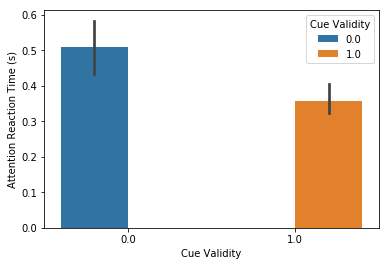

In [7]:
sb.barplot(x='Cue Validity',y='Attention Reaction Time (s)', hue='Cue Validity',data=df[df['Trial Type']=='Presentation'])

In [9]:
# Add the Attention Level labels from presentation to the Memory Images

cued_cat = df[df['Trial Type']=='Presentation']['Cued Category'].tolist()[0]

for index,row in df.iterrows():
    
    if row['Trial Type']=='Memory':
        mem_image = row['Memory Image']
        # for mem_image in df[df['Trial Type']=='Memory']['Memory Image'].tolist(): 
        # loop over rows in memory chunk and pull memory image from each

        for cue in ['Cued ', 'Uncued ']:
            for cat in ['Face', 'Place']:
                if df.loc[df[cue+cat] == mem_image].shape[0]!=0:
                    if cat == cued_cat:
                        df['Category'][index]=cued_cat
                        if cue == 'Cued ':
                            attention = "Full"
                        elif cue == 'Uncued ': 
                            attention = "Category"
                    else:
                        df['Category'][index]=cat
                        if cue == 'Uncued ':
                            attention = "None"
                        elif cue == 'Cued ': 
                            attention = "Side"  
                    df['Attention Level'][index] = attention
                    

/Users/Student/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Student/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/Student/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

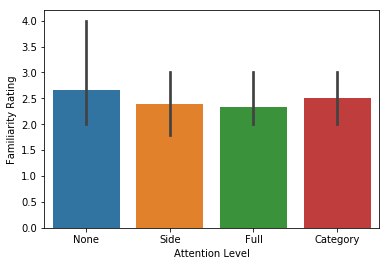

In [10]:
sb.barplot(x='Attention Level',y='Familiarity Rating',data=df)

In [27]:
df.shape[0]

50

In [19]:
mem_mask = df['Trial Type']=='Memory'
df.loc[mem_mask,'Attention Level'] = df.loc[mem_mask,'Attention Level'].fillna('Novel')

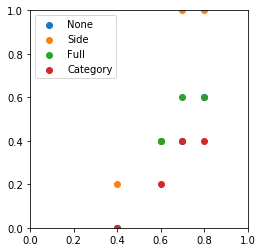

In [72]:
# make and display ROC data (not by category)
import matplotlib.pyplot as plt

ratings = [1.0, 2.0, 3.0, 4.0]
ROC = {}

fig = plt.figure()
ax1 = fig.add_subplot(111)

# for each attention level
for attn in ['Novel', 'None','Side','Full','Category']:
    ROC[attn] = []
    
    # for each possible number rating
    for idx in range(len(ratings)):
        
        # proportion of times they rated that attn level & proportion of Novel that got that rating
        num = df.loc[(df['Attention Level'] == attn) & df['Familiarity Rating'].isin(ratings[:idx+1])].shape[0]
        denom = df.loc[df['Attention Level'] == attn].shape[0]
        ROC[attn].append(float(num)/denom)
    
    if attn != 'Novel':
        ax1.scatter(ROC['Novel'], ROC[attn], label=attn)
    
plt.legend(loc='upper left');
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()
        